In [1]:
import os
import numpy as np
from PIL import Image,ImageEnhance,ImageDraw
from matplotlib.pyplot import imshow
%matplotlib inline

In [2]:
def add_rect(im, x, y, size = 20,fill = None,outline = None):
    draw = ImageDraw.Draw(im)
    draw.rectangle(( (x,y), (x+size,y+size) ) , fill = fill,outline = outline)
    del draw

In [3]:
def img_by_class(im,txtFile,clss_index,image_size = 32,output_name = None):
    file_train = open(txtFile,"r")
    for line in file_train:
        # break
        line = line.split(' ')
        x = int(line[0].strip())
        y = int(line[1].strip())
        x -= int(image_size/2)
        y -= int(image_size/2)
        if x < 0:
            x = 0
        if y < 0:
            y = 0

        add_rect(im,x,y,size = image_size)

    file_test = open("../raw_iputs/validationPoints.txd")
    print("hi")
    for line in file_test:
        line = line.split(' ')
        # x and y coordinates in this file is reversed for some reason
        x = int(line[1].strip())
        y = int(line[0].strip())
        l = int(line[2].strip())

        if(l != clss_index):
            continue
        print(l)
        x -= int(image_size/2)
        y -= int(image_size/2)
        if x < 0:
            x = 0
        if y < 0:
            y = 0

        add_rect(im,x,y,size = image_size,outline = 128)
        # break

    # add_rect(im,300,300)
    im.show()
    if output_name != None:
        assert type(output_name) == type("string"),"output_name should be string"
        im.save(output_name,"png")
    del im

In [4]:
def create_k_band_array(bands, k):
    
    image = []
    
    for x in range(bands[0].shape[0]):
        row = []
        for y in range(bands[0].shape[1]):
            pixel = []
            for ks in k:
                pixel.append(bands[int(ks),x,y])
            row.append(pixel)
        image.append(np.array(row))


    return np.array(image,dtype = np.float64)

In [5]:
load_path = "../raw_iputs"

In [6]:
file_path = load_path + "/validationPoints.txd"
image_paths = []
imarrays = []
bands = ["1","2","3","4","5","6","7","8","8a","9","10","11","12"]
for i in bands:
    # get path and add to list
    path = load_path + "/k"+ str(i) + "b.tif"
    image_paths.append(path)
    # load image, conver it to np array and add to list
    im = Image.open(path)
    imarray = np.array(im)
    imarrays.append(imarray)

# convert imarrays to np array
imarrays = np.array(imarrays)
imarrays.shape
# combine these arrays into a k band array

(13, 1981, 2000)

In [7]:
combined_13band = create_k_band_array(imarrays,k = range(imarrays.shape[0]))
combined_13band.shape

(1981, 2000, 13)

In [8]:
combined_3band = create_k_band_array(imarrays,k = [3,2,1])# R = 4, G = 3, B = 2 and -1 for positions
combined_3band.shape

(1981, 2000, 3)

## Lets draw image

We need to turn image into RGB image. This might cause some distortion. 

1. normalize 
2. increase brightness

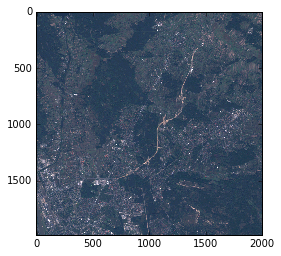

In [9]:
combined = np.copy(combined_3band)
# normalize
combined /= 28000
# turn np array into image
im = Image.fromarray(np.uint8(combined*255))

# increase brightness
enhancer = ImageEnhance.Brightness(im)
im = enhancer.enhance(10)#.show()

cont = ImageEnhance.Contrast(im)
im = cont.enhance(1)
imshow(im)
im.save("RGB_city","JPEG")
del combined

In [10]:
def sub_train_set(imarray, coor_path, clss_index,x_size,y_size):
    file_train = open(coor_path,"r")
    X = []
    coor = []
    for line in file_train:
        line = line.split(' ')
        x = int(line[0].strip())
        y = int(line[1].strip())
        coor.append((x,y))
        x -= int(x_size / 2)
        y -= int(y_size / 2)

        if x < 0:
            x = 0
        if y < 0:
            y = 0

        if x + x_size > imarray.shape[0]:
            x = imarray.shape[0] - x_size
        if y + y_size > imarray.shape[1]:
            y = imarray.shape[1] - y_size

        img = imarray[y:y+y_size,x:x+x_size]
        X.append(img)
    # Y = np.ones([len(X),1]) * clss_index
    Y = np.ones([len(X),]) * clss_index
    # print(y)
    return np.array(X), Y, coor

In [11]:
def sub_valid_set(imarray,coor_path,x_size,y_size):
    file_train = open(coor_path,"r")
    X = []
    labels = []
    coor = []
    for line in file_train:
        line = line.split(' ')
        x = int(line[1].strip())
        y = int(line[0].strip())
        l = int(line[2].strip())
        # l is undefined
        if l == 5:
            continue
        labels.append(l)
        coor.append((x,y))
        x -= int(x_size / 2)
        y -= int(y_size / 2)

        if x < 0:
            x = 0
        if y < 0:
            y = 0

        if x + x_size > imarray.shape[0]:
            x = imarray.shape[0] - x_size
        if y + y_size > imarray.shape[1]:
            y = imarray.shape[1] - y_size

        img = imarray[y:y+y_size,x:x+x_size]
        X.append(img)
    Y = np.ones([len(X),])
    for i,l in enumerate(labels):
        Y[i] *= l
    # print(y)
    return np.array(X), Y, coor

In [12]:
def one_hot(Y, v_min = 1, v_max = 4):
    vectors = []
    for y in Y:
        v = np.zeros([v_max - v_min + 1])
        v[int(y - 1)] = 1
        vectors.append(v)
    return vectors

In [13]:
def create_dataset(imarray,image_size,save_path, one_hot = False):
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    X,Y, _ = sub_train_set(imarray, "../raw_iputs/agriculture.txd", 1,
                           image_size ,image_size )
    
    x,y, _ = sub_train_set(imarray, "../raw_iputs/biultup.txd", 3,
                           image_size ,image_size )
    X = np.concatenate((X,x),axis = 0)
    Y = np.concatenate((Y,y), axis = 0)
    
    x,y, _ = sub_train_set(imarray, "../raw_iputs/treeCover.txd", 2,
                           image_size ,image_size )
    X = np.concatenate((X,x),axis = 0)
    Y = np.concatenate((Y,y), axis = 0)
    
    x,y, _ = sub_train_set(imarray, "../raw_iputs/waterBodies.txd", 4,
                           image_size ,image_size )
    X = np.concatenate((X,x),axis = 0)
    Y = np.concatenate((Y, y), axis = 0)
    
    X_valid,Y_valid, _ = sub_valid_set(imarray, "../raw_iputs/validationPoints.txd",
                                       image_size ,image_size )
    
    if one_hot:
        Y = one_hot(Y)
        Y_valid = one_hot(Y_valid)
    
    np.save(save_path + "X_train.npy",X)
    np.save(save_path + "Y_train.npy",Y)

    np.save(save_path + "X_valid.npy",X_valid)
    np.save(save_path + "Y_valid.npy",Y_valid)
    
    # for debugging purposes
    return X.shape

In [14]:
create_dataset(combined_13band,9,"../data_9x9_13band/")

(404, 9, 9, 13)

In [15]:
create_dataset(combined_13band,32,"../data_32x32_13band/")

(404, 32, 32, 13)

In [16]:
create_dataset(combined_3band,9,"../data_9x9_3band/")

(404, 9, 9, 3)

In [17]:
create_dataset(combined_3band,32,"../data_32x32_3band/")

(404, 32, 32, 3)